In [1]:
# Imports
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import torch
from torch import nn
from torch.utils import data as data_torch
import random
from tqdm import tnrange, tqdm_notebook
from PIL import Image

In [2]:
import gpustat
gpustat.print_gpustat()

noyse                       Sat Nov 26 10:35:07 2022  470.141.03
[0] NVIDIA GeForce RTX 2080 | 29°C,   0 % |    50 /  7979 MB | gdm(35M) gdm(10M)
[1] NVIDIA GeForce RTX 2080 | 35°C,   0 % |     8 /  7982 MB | gdm(4M)
[2] NVIDIA GeForce RTX 2080 | 27°C,   0 % |     8 /  7982 MB | gdm(4M)
[3] NVIDIA GeForce RTX 2080 | 27°C,   0 % |     8 /  7982 MB | gdm(4M)


In [3]:
path_dir = '/HomeToo/Projects/TerraSphere_FeatureExtraction/archive_folder/CopyPaste/datasets/taller/data/RarePlusRoadFractures'#datasets/data/RarePlusRoadFractures'
partitions = ['train', 'val','test']
# size_image = 

In [4]:
import os 
os.listdir(path_dir)

['val', 'test', 'train']

In [5]:
images_dic = {'train':[], 'val':[], 'test':[]}
label_dic = {'train':[], 'val':[], 'test':[]}
size_images = []
max_img = 3000
for phase in partitions:
    
    path_phase_images = path_dir+'/%s/images'%phase
    path_phase_labels = path_phase_images.replace('images', 'labels')
    name_images = os.listdir(path_phase_images)
    images = [cv2.imread('%s/%s'%(path_phase_images,x), cv2.IMREAD_COLOR) for x in name_images[0:max_img]]
    labels = [cv2.imread('%s/%s'%(path_phase_labels,x), cv2.IMREAD_COLOR) for x in name_images[0:max_img]]
    images_dic[phase] = images
    label_dic[phase] = labels
    size_images = [x.shape for x in images_dic[phase][0:max_img]]
    
# img.shape
# plt.imshow(img)

In [102]:
images_dic['train'][0].shape
# label_dic['train'][0][:,:0].shape

(378, 504, 3)

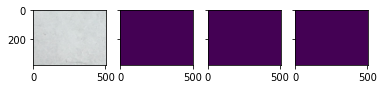

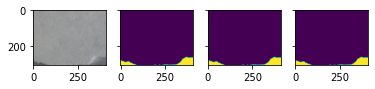

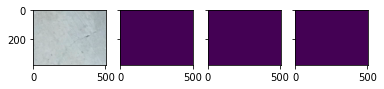

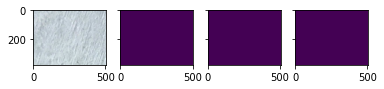

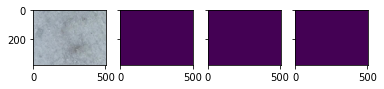

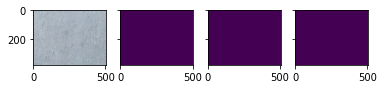

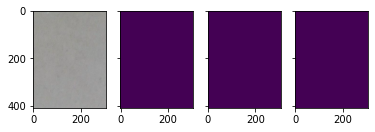

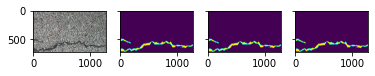

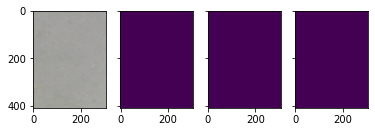

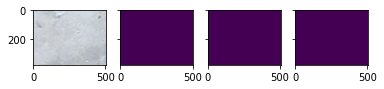

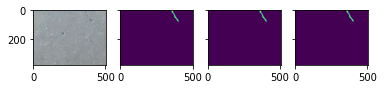

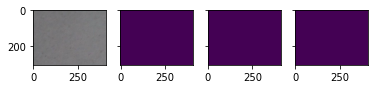

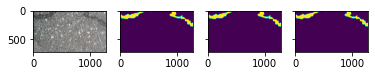

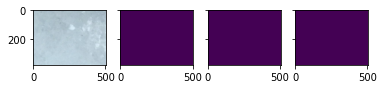

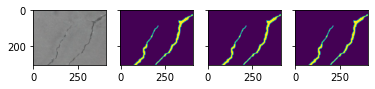

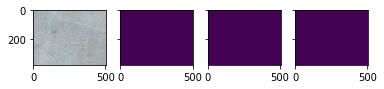

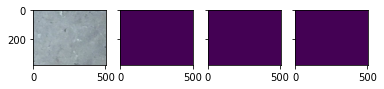

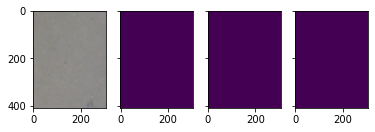

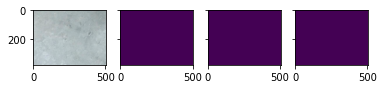

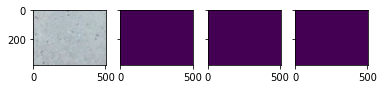

In [44]:
# verificar imágenes y etiquetas
import random
index_sample = random.sample(list(range(len(images_dic['train']))), 20)
for img_i in index_sample:
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
    ax1.imshow(images_dic['train'][img_i])
#     print(label_dic['train'][img_i][0].shape)
    ax2.imshow(label_dic['train'][img_i][:,:,0])
    ax3.imshow(label_dic['train'][img_i][:,:,1])
    ax4.imshow(label_dic['train'][img_i][:,:,2])

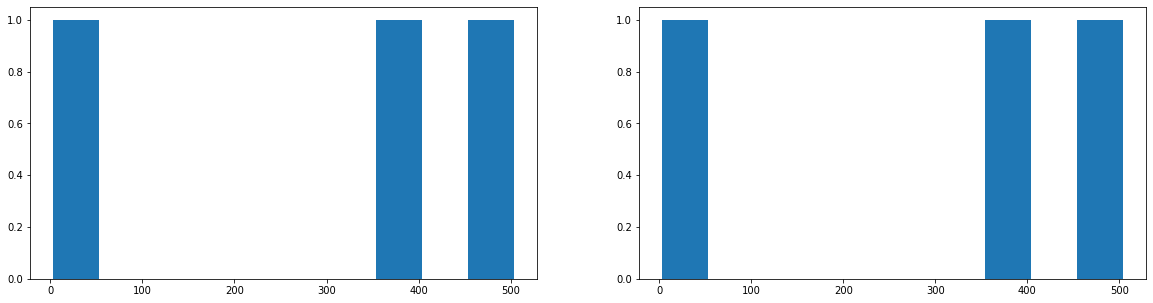

In [6]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,5))
ax1.hist(size_images[0])
ax2.hist(size_images[1])
plt.show()


In [6]:
from skimage.transform import resize
class Image_Loader(data_torch.Dataset):
    def __init__(self, list_patches, list_labels, size_image):

        self.list_patches = list_patches
        self.list_labels = list_labels
        self.size_image = size_image
        
        
    def __getitem__(self, index):
        patch = self.list_patches[index]
        labels = self.list_labels[index]
        patch = resize(patch, self.size_image)
        labels = resize(labels, self.size_image)
        
        return patch, labels[:,:,0]
        

    def __len__(self):
        return len(self.list_labels)

In [7]:
partitions = ['train', 'val', 'test']
batch_size = {'train':24,'val':24,'test':1}
shuffle = {'train':True,'val':False,'test':False}
size_images = (180,180)
lr = 0.001
Img_datasets = {x: Image_Loader(images_dic[x], label_dic[x], size_images) for x in partitions}
dataloaders = {x: torch.utils.data.DataLoader(Img_datasets[x], batch_size=batch_size[x],\
                                              shuffle=shuffle[x]) for x in partitions}
dataset_sizes = {x: len(Img_datasets[x]) for x in partitions}
print('Data loaded correctly!')
dataset_sizes

Data loaded correctly!


{'train': 3000, 'val': 1388, 'test': 1572}

In [8]:
class AutoEncoder_TS(nn.Module):
    def __init__(self):
        super(AutoEncoder_TS, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels=1,out_channels=32,kernel_size=6,stride=2,padding=3)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.2)
        self.conv2 = nn.Conv1d(in_channels=32,out_channels=16,kernel_size=6,stride=2,padding=3)
        self.convTrans = nn.ConvTranspose1d(in_channels=16, out_channels=16,kernel_size=6,stride=2,padding=3)
        self.convTrans2 = nn.ConvTranspose1d(in_channels=16, out_channels=32,kernel_size=6,stride=2,padding=2)
        self.convTrans3 = nn.ConvTranspose1d(in_channels=32, out_channels=1,kernel_size=5,stride=1, padding=2)
    def forward(self, x):
        
        x = self.dropout(self.relu(self.conv1(x)))
        x = self.relu(self.conv2(x))
        x = self.dropout(self.relu(self.convTrans(x)))
        x = self.relu(self.convTrans2(x))
        x = self.convTrans3(x)
        return x

In [9]:
class Resnet_seg(nn.Module):    
    def __init__(self, model, size_image,  **kwargs):
            super(Resnet_seg, self).__init__()
            self.kernel_W, self.kernel_H = 2,2
            self.size_image = size_image
            self.relu = nn.ReLU()
            self.dropout = nn.Dropout(p=0.5)
            self.features = nn.Sequential(
                    model.conv1,
                    model.bn1,
                    model.relu,
                    model.layer1,
                    model.layer2,
                    model.layer3,
                    model.layer4)
            
            self.deconv  = nn.Conv2d(512, 1, kernel_size=2, stride=1, padding=0)#nn.ConvTranspose2d(in_channels=512, out_channels=256,kernel_size=32,stride=2,padding=3)
#             self.deconv2  = nn.ConvTranspose2d(in_channels=256, out_channels=128,kernel_size=32,stride=2,padding=3)
#             self.deconv3  = nn.ConvTranspose2d(in_channels=128, out_channels=1,kernel_size=24,stride=2,padding=3)
#             nn.Conv2d(512, 1, kernel_size=2, stride=1, padding=0)
            self.sigmoid = nn.Sigmoid()
    

    def forward(self, x):
        x = self.features(x)
        y_seg = self.deconv(x)
#         print(x.shape)
#         y_seg = self.dropout(self.relu(self.deconv(x)))
        
#         y_seg = self.relu(self.deconv2(y_seg))
        
#         y_seg = self.deconv3(y_seg)
        y_seg = self.sigmoid(y_seg) 
        
        y_seg_resize = nn.functional.interpolate(y_seg, size=self.size_image)

        return y_seg, y_seg_resize, x

In [12]:
from torch import nn
import torchvision.models as models
from torch.autograd import Variable
from torch.optim import Optimizer
from torchvision import transforms
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
backbone = models.resnet18(pretrained=True)
model = Resnet_seg(backbone, size_images)

model.to(device);
criterionBCE = nn.BCELoss()#nn.BCELoss()#DiceBCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)#AddSign(model.parameters(), lr=lr)0.01
del backbone;
print('model')

model


In [92]:
model

Resnet_seg(
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReL

In [85]:
from torchsummary import summary
summary(model.cuda(), (3,180,180))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 90, 90]           9,408
       BatchNorm2d-2           [-1, 64, 90, 90]             128
              ReLU-3           [-1, 64, 90, 90]               0
            Conv2d-4           [-1, 64, 90, 90]          36,864
       BatchNorm2d-5           [-1, 64, 90, 90]             128
              ReLU-6           [-1, 64, 90, 90]               0
            Conv2d-7           [-1, 64, 90, 90]          36,864
       BatchNorm2d-8           [-1, 64, 90, 90]             128
              ReLU-9           [-1, 64, 90, 90]               0
       BasicBlock-10           [-1, 64, 90, 90]               0
           Conv2d-11           [-1, 64, 90, 90]          36,864
      BatchNorm2d-12           [-1, 64, 90, 90]             128
             ReLU-13           [-1, 64, 90, 90]               0
           Conv2d-14           [-1, 64,

train || epoch-0: lossB = 0.00401


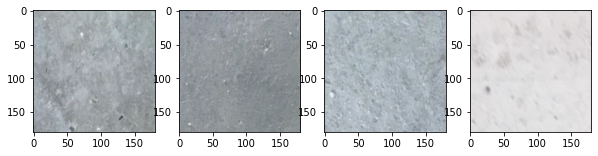

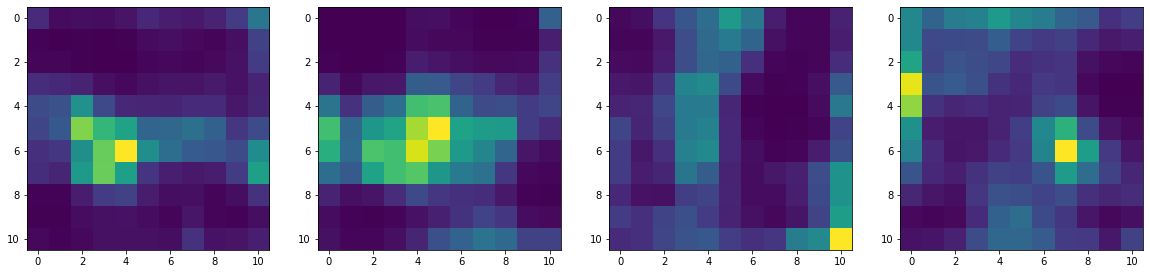

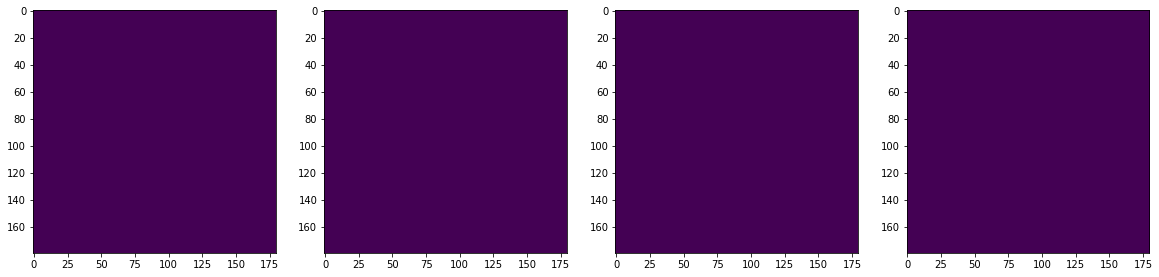

val || epoch-0: lossB = 0.00315


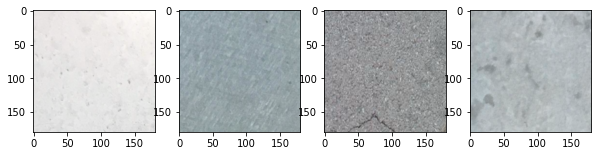

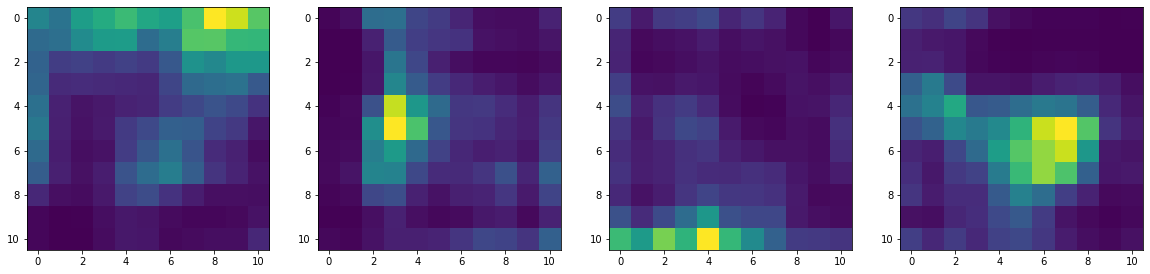

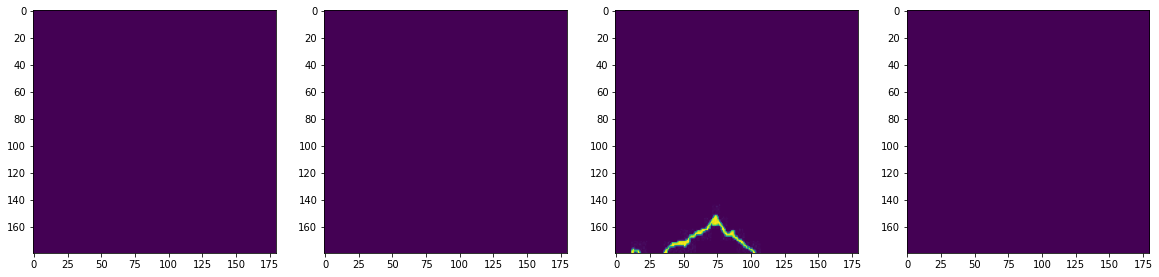

train || epoch-1: lossB = 0.00227


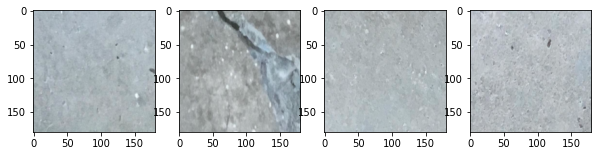

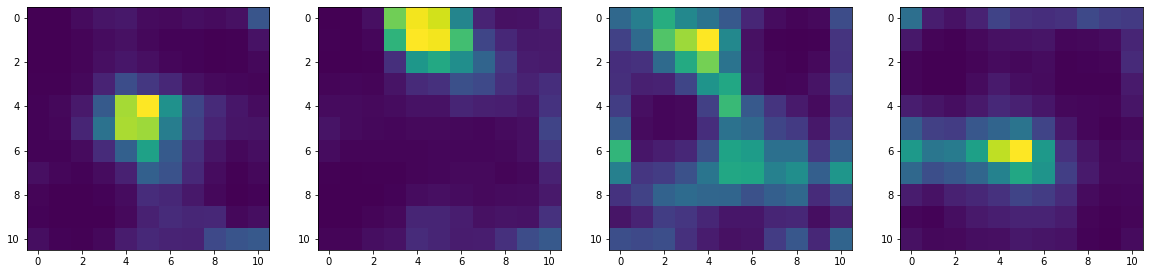

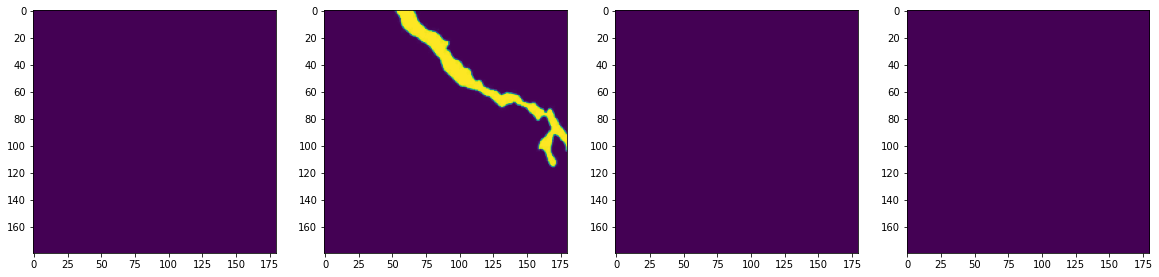

val || epoch-1: lossB = 0.00237


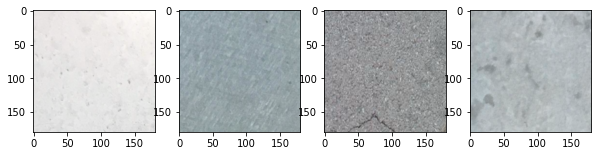

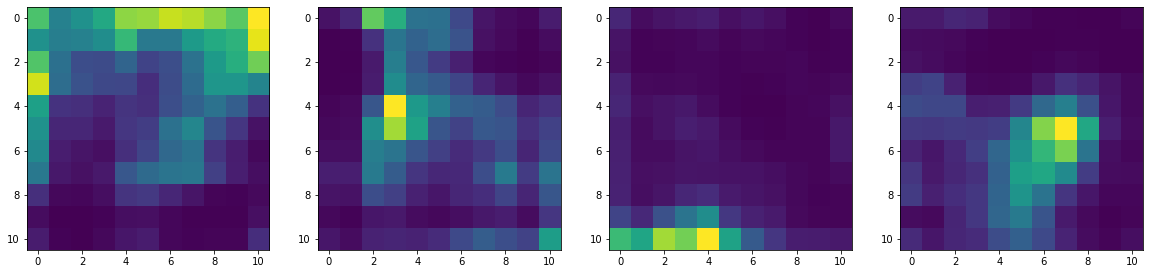

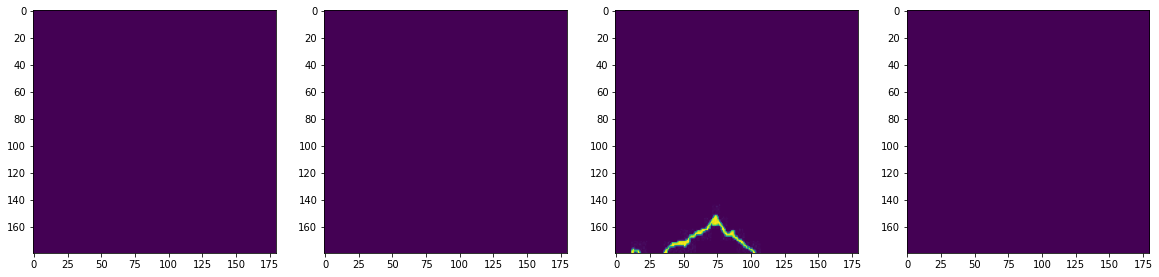

train || epoch-2: lossB = 0.00189


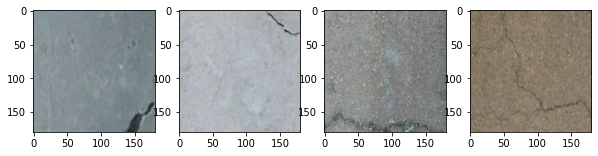

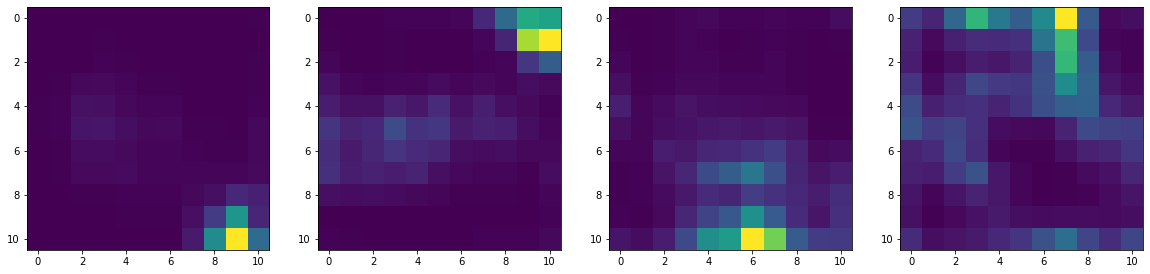

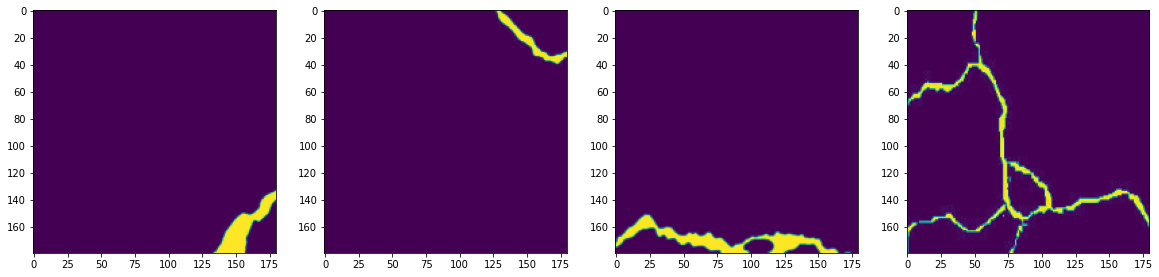

val || epoch-2: lossB = 0.00215


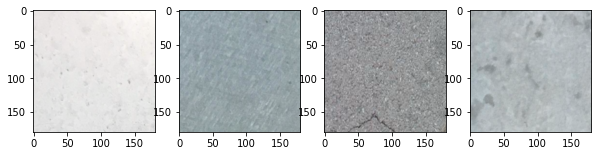

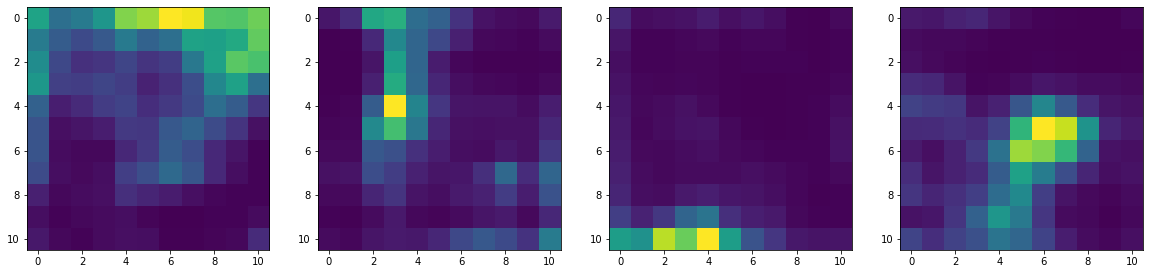

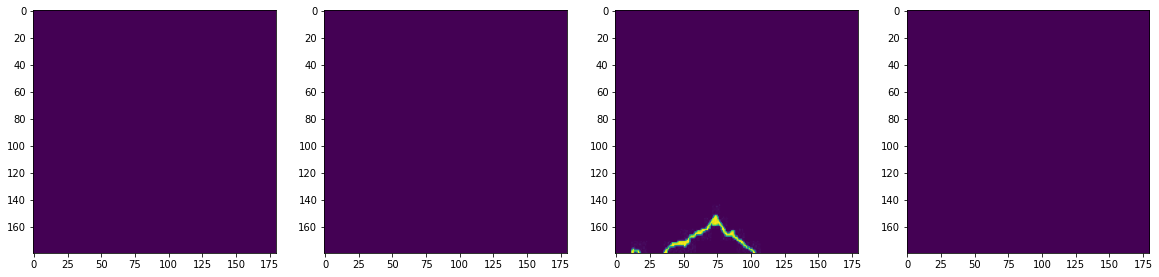

train || epoch-3: lossB = 0.00176


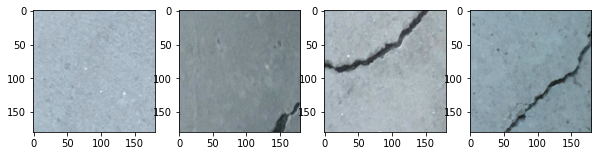

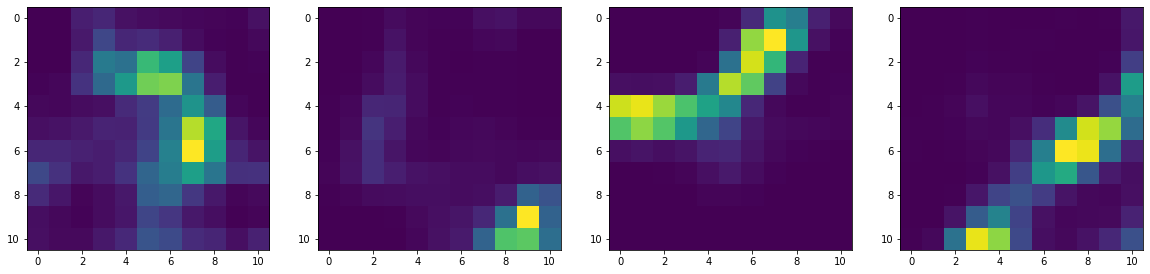

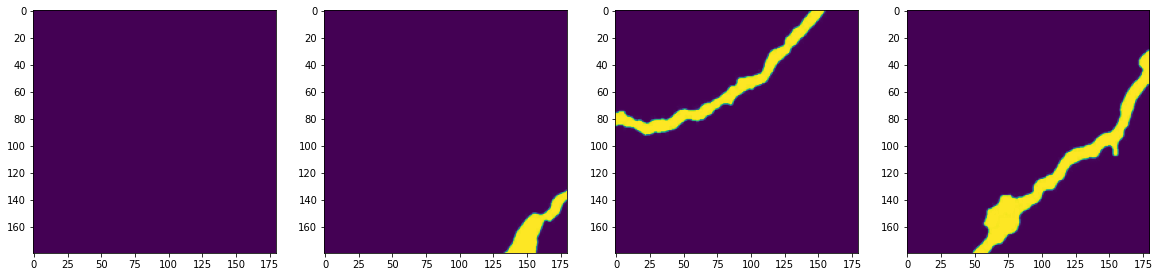

val || epoch-3: lossB = 0.00204


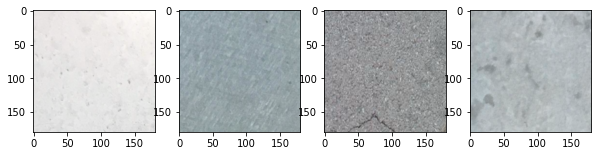

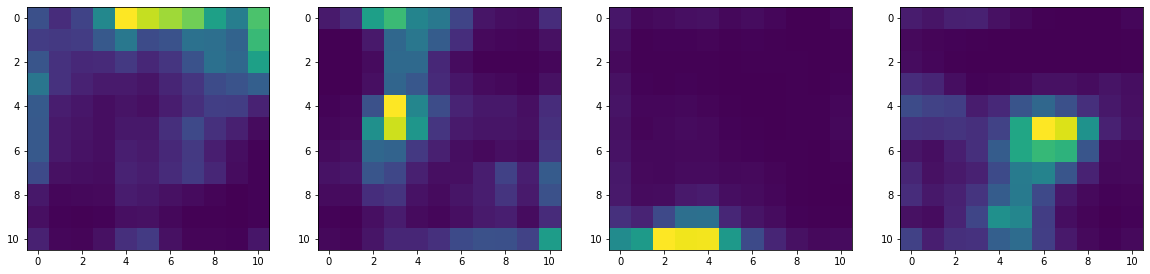

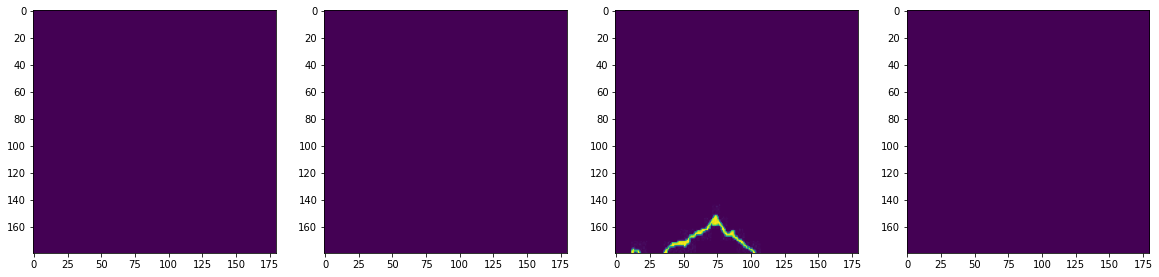

train || epoch-4: lossB = 0.00168


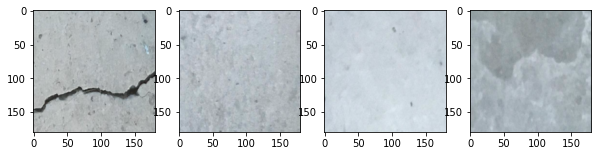

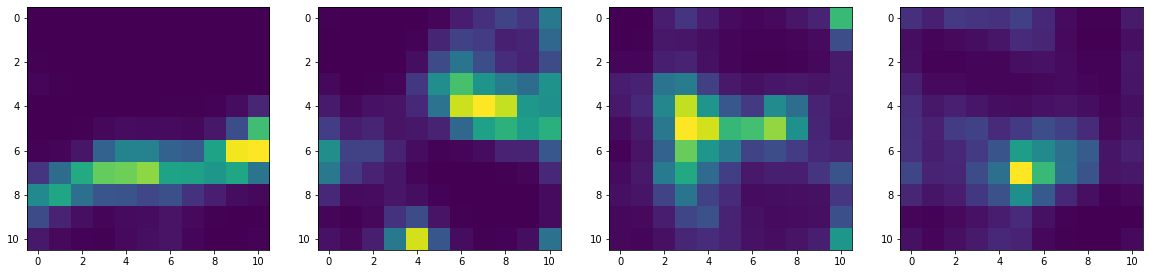

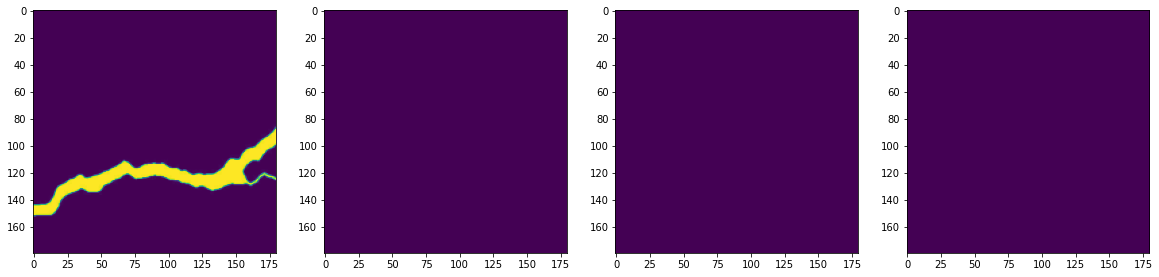

val || epoch-4: lossB = 0.00199


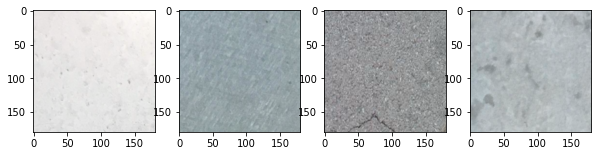

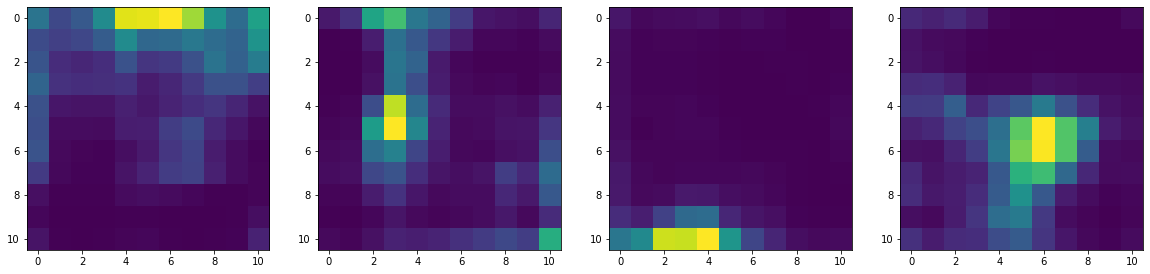

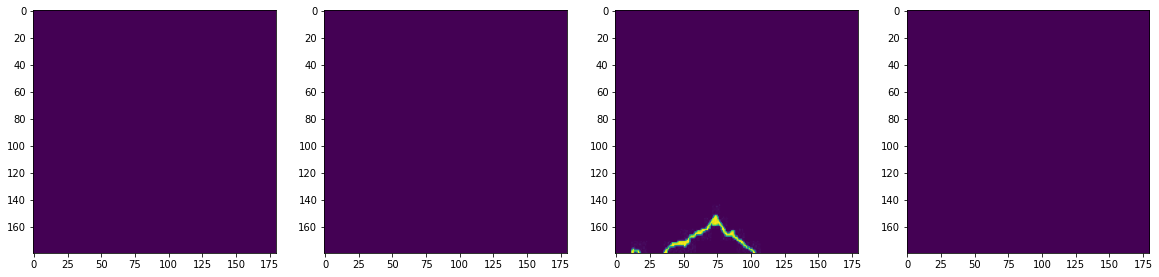

train || epoch-5: lossB = 0.00162


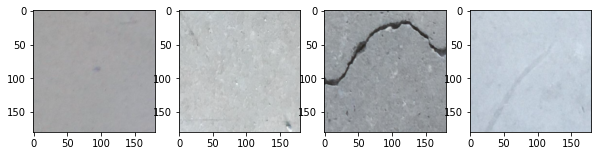

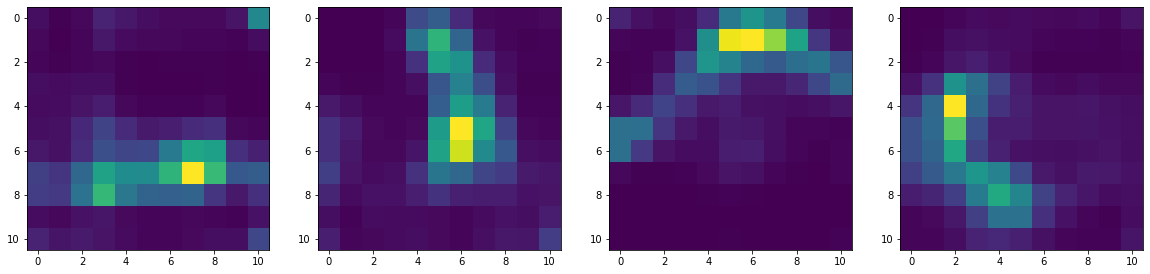

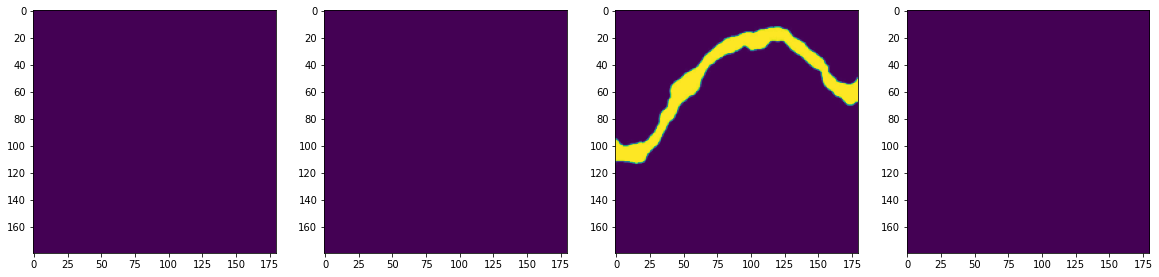

val || epoch-5: lossB = 0.00196


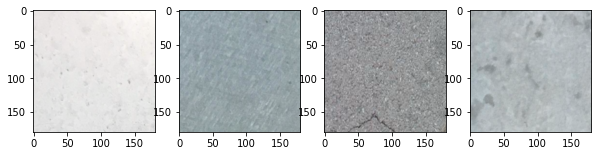

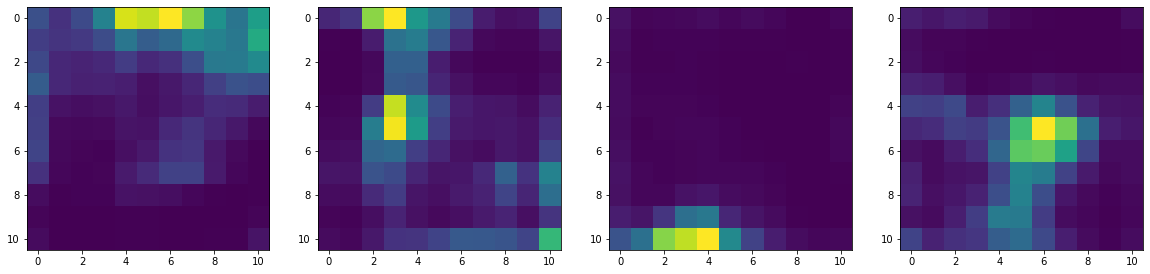

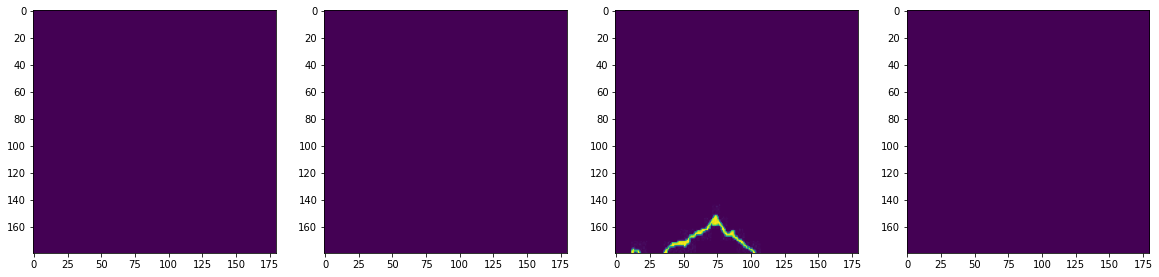

train || epoch-6: lossB = 0.00159


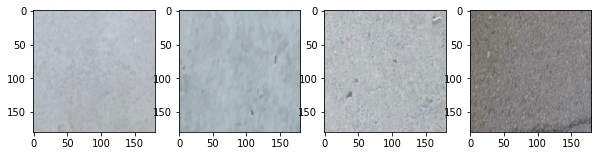

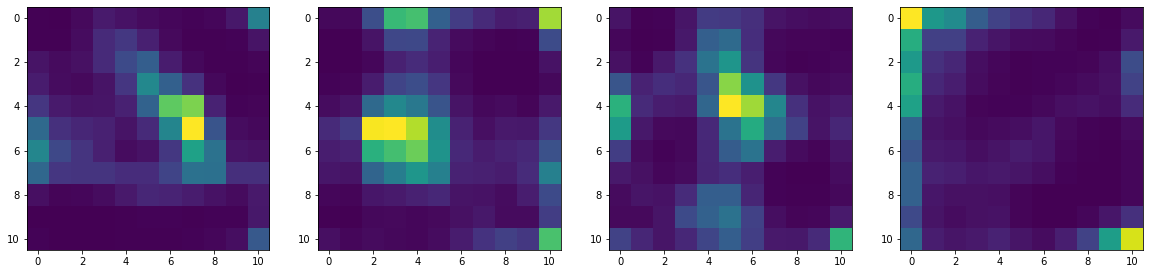

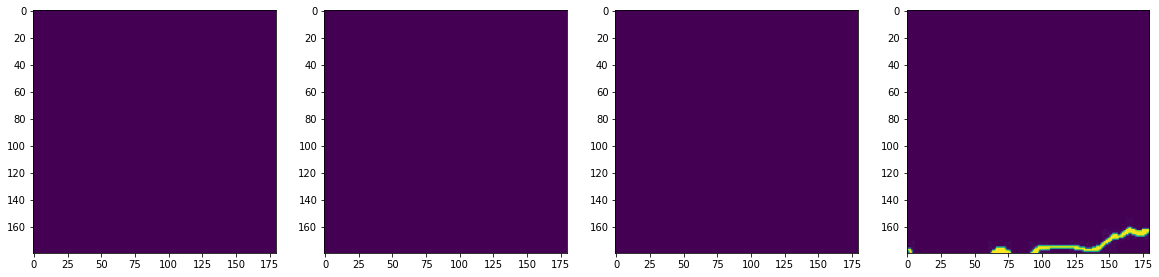

val || epoch-6: lossB = 0.00191


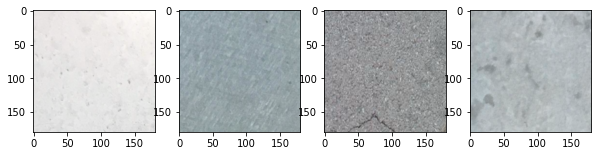

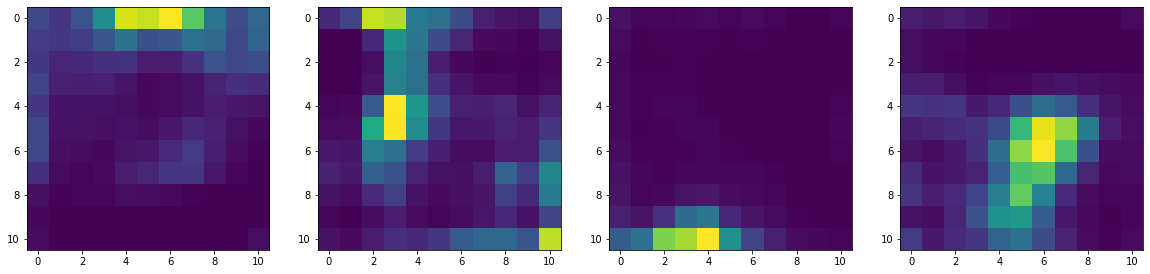

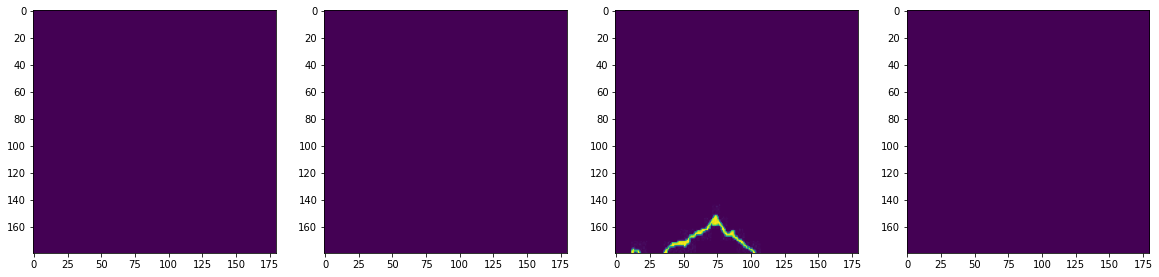

train || epoch-7: lossB = 0.00156


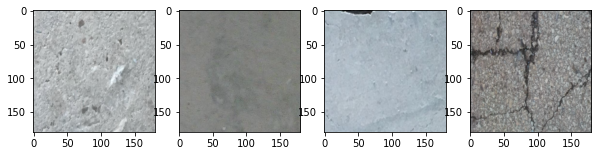

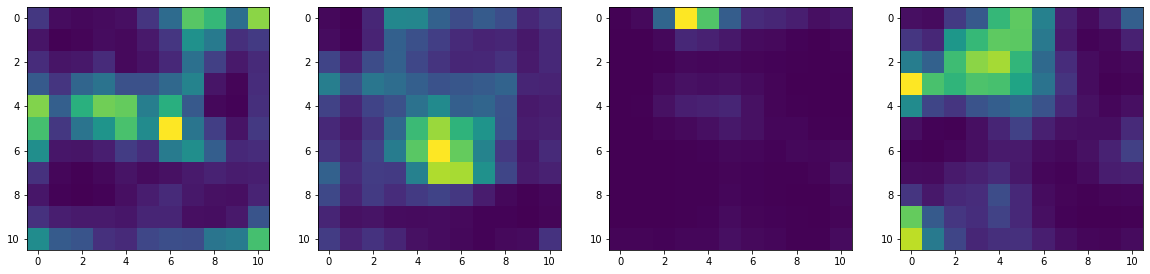

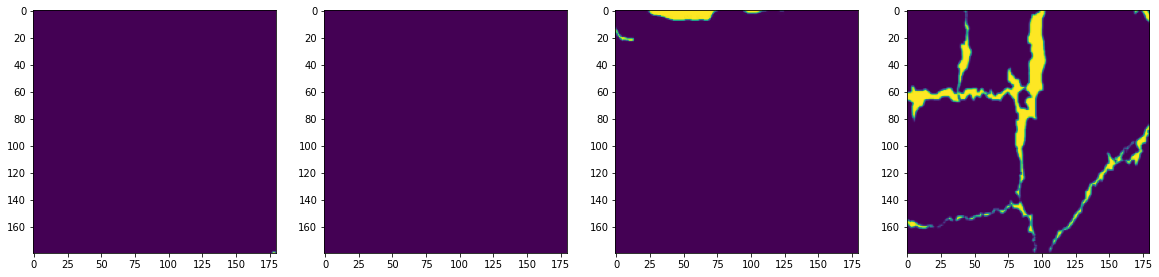

val || epoch-7: lossB = 0.00187


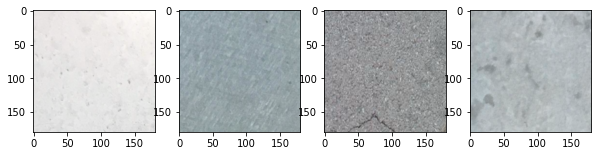

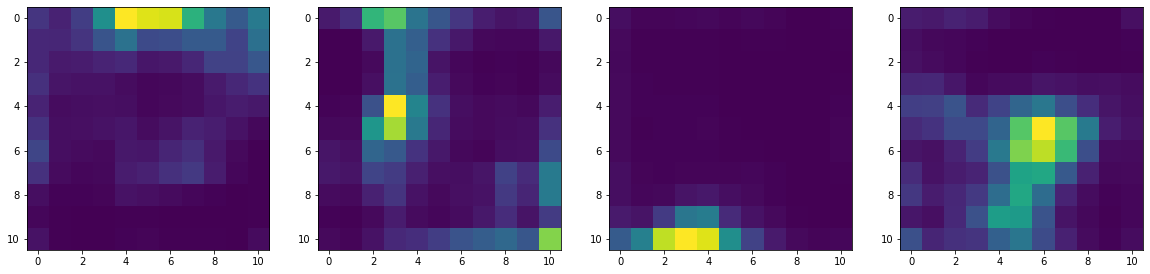

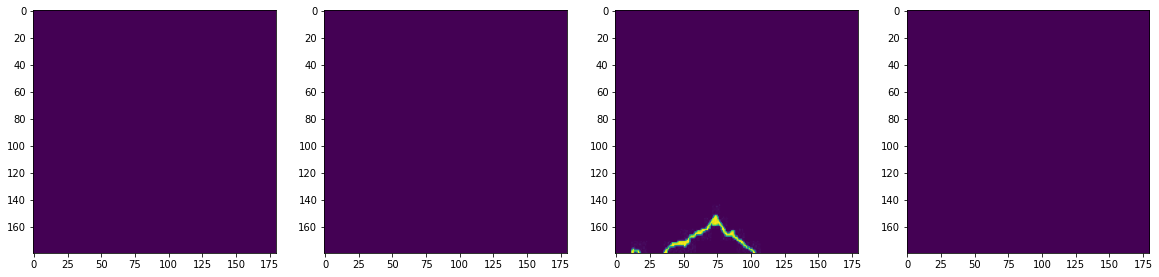

In [ ]:
loss_dic = {'train':[], 'val':[]}
for epoch in range(0, 20):

    iter_current = 0
    loss_epoch = 0
    for phase in partitions[0:2]:           
        if phase == partitions[0]:
            model.train()
        else:
            model.eval() 
        running_loss = 0.0

        for k, batch_data in enumerate(dataloaders[phase]):
            patch, label  = batch_data
            
            patch, label = patch.float(), label.float()
            patch, label = patch.to(device), label.to(device)
            patch = patch.permute((0,3,1,2))
            label = label.squeeze()
#             print(patch.shape, label.shape)

            optimizer.zero_grad()
            #===================
            # Forward
            #=====================
            x, output_seg_resize, _ = model(patch)
#             print(output_seg.shape)
#             break
            

            #=====================
            # Compute loss
            #=====================
            loss = criterionBCE(output_seg_resize.squeeze().float(), label.float())
#             loss = loss.to(device)
            #===================
            # backward
            #=====================
            if phase == partitions[0]:
                loss.backward()
                optimizer.step()

            running_loss += loss.item()

            iter_current += 1

        loss_epoch =  running_loss / float(dataset_sizes[phase])

        if iter_current%100 == 0:
            print('iter-%s'%iter_current)

        print("%s || epoch-%s: lossB = %.5f"%(phase, epoch, loss_epoch))

        loss_dic[phase].append(loss_epoch)
        # visualizando la CNN
        # Visualizando el mapa de caracteristicas
        f, ax = plt.subplots(1, 4, figsize=(10,10))
        ax[0].imshow(patch.detach().permute((0,2,3,1)).cpu().numpy()[0])
        ax[1].imshow(patch.detach().permute((0,2,3,1)).cpu().numpy()[1])
        ax[2].imshow(patch.detach().permute((0,2,3,1)).cpu().numpy()[2])
        ax[3].imshow(patch.detach().permute((0,2,3,1)).cpu().numpy()[3])
        plt.show()
        
        f, ax = plt.subplots(1, 4, figsize=(20,20))
        ax[0].imshow(x.detach().squeeze().cpu().numpy()[0])
        ax[1].imshow(x.detach().squeeze().cpu().numpy()[1])
        ax[2].imshow(x.detach().squeeze().cpu().numpy()[2])
        ax[3].imshow(x.detach().squeeze().cpu().numpy()[3])
        plt.show()
        
        f, ax = plt.subplots(1, 4, figsize=(20,20))
        ax[0].imshow(label.detach().squeeze().cpu().numpy()[0])
        ax[1].imshow(label.detach().squeeze().cpu().numpy()[1])
        ax[2].imshow(label.detach().squeeze().cpu().numpy()[2])
        ax[3].imshow(label.detach().squeeze().cpu().numpy()[3])
        plt.show()
        # Visualize filters
        #Task

    torch.save(model.state_dict(), '/HomeToo/Projects/TerraSphere_FeatureExtraction/archive_folder/CopyPaste/datasets/taller/results/model-epoch%s.ckpt'%epoch)

NameError: name 'img_arr' is not defined

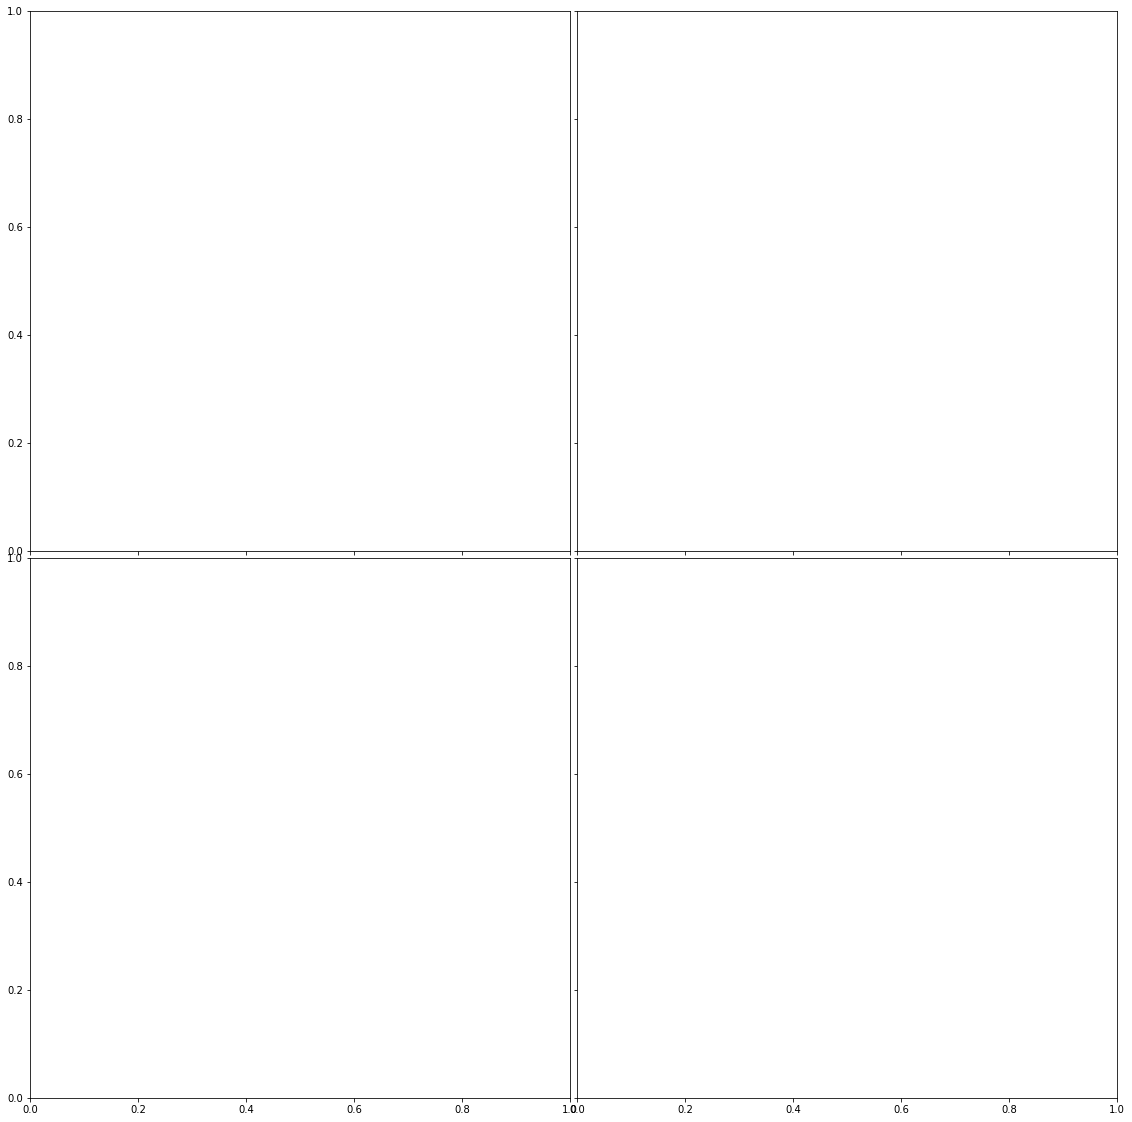

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(2, 2),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes
                 )

for ax, im in zip(grid, img_arr):
    ax.imshow(im)

plt.show()